In [1]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
from google.cloud import storage

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import glob
import os
import io

In [6]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *
import numpy as np

In [7]:
client = storage.Client()
bucket_name = 'my-project-bucket-jl'
bucket = client.get_bucket(bucket_name)
elements = bucket.list_blobs()
csv_files=[a.name for a in elements]

In [8]:
mlb_gameday_cleaned_list = []
for file in csv_files:
    filename = 'gs://my-project-bucket-jl/' + file + ''
    word = 'revised'
    if word not in filename: 
        continue 
    else: 
        df = filename
        mlb_gameday_cleaned_list.append(df)

In [9]:
mlb_gameday_list = []
for file in mlb_gameday_cleaned_list:
    try:
        filename = file 
        df = pd.read_parquet(filename)
        if df.empty:
            continue
        else:
            filename = file 
            print(filename)
            df = spark.read.parquet(filename)
            mlb_gameday_list.append(df)
    except pd.errors.EmptyDataError:
        continue

gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_04


gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_05
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_06
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_07


gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_08
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_09
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_10
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_04
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_05
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_06
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_07
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_08
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_09
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_10
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2007_03
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2007_04
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2007_05

gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_04
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_05
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_06
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_07
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_08
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_09
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_10
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2020_07
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2020_08
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2020_09
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2020_10
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2021_03
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2021_04

In [10]:
merged_mlb_gameday_list_df = None
for df in mlb_gameday_list: 
    if merged_mlb_gameday_list_df == None: 
        merged_mlb_gameday_list_df = df 
    else: 
        merged_mlb_gameday_list_df = merged_mlb_gameday_list_df.union(df)

In [11]:
new_merged_mlb_gameday_list_df = merged_mlb_gameday_list_df.fillna(0)

In [12]:
got_on_base = ['single','home_run','double','walk',
               'hit_by_pitch','triple','catcher_interf',
               'fielders_choice','field_error','intent_walk']
at_bat_continues = [None,'truncated_pa','injury',
                    'ejection','game_advisory']
out = ['field_out','strikeout','sac_fly','grounded_into_double_play',
       'force_out','sac_bunt','fielders_choice_out','double_play',
       'strikeout_double_play','triple_play', 'sac_fly_double_play', 
       'sac_bunt_double_play','strikeout_triple_play']
def events_outcome(x):
    if x in at_bat_continues: 
        return 1
    elif x in out:
        return 0
    elif x in got_on_base:
        return 2
events_outcome_udf = udf(events_outcome)


In [13]:
new_merged_mlb_gameday_list_df = new_merged_mlb_gameday_list_df.withColumn('event_outcome',events_outcome_udf('events'))

In [14]:
new_merged_mlb_gameday_list_df = new_merged_mlb_gameday_list_df.withColumn("player_on_1b", when(new_merged_mlb_gameday_list_df.on_1b == 0.0, 0.0).otherwise(1.0))

In [15]:
new_merged_mlb_gameday_list_df = new_merged_mlb_gameday_list_df.withColumn("player_on_2b", when(new_merged_mlb_gameday_list_df.on_2b == 0.0, 0.0).otherwise(1.0))

In [16]:
new_merged_mlb_gameday_list_df = new_merged_mlb_gameday_list_df.withColumn("player_on_3b", when(new_merged_mlb_gameday_list_df.on_3b == 0.0, 0.0).otherwise(1.0))

In [17]:
new_merged_mlb_gameday_list_df = new_merged_mlb_gameday_list_df.withColumn("label",when(new_merged_mlb_gameday_list_df.pitch_type == "FF", 1.0).otherwise(0.0) )

In [18]:
indexer = StringIndexer(inputCols=["batter", "pitcher",'stand','p_throws','type',
                                   'inning_topbot','game_pk','event_outcome',
                                   'game_year'], 
                        outputCols=["batterIndex", 
                                    "pitcherIndex",'standIndex','p_throwsIndex',
                                    'typeIndex','inning_topbotIndex','game_pkIndex',
                                    'event_outcomeIndex','game_yearIndex'],
                       handleInvalid= "skip")

In [19]:
encoder = OneHotEncoder(inputCols=["batterIndex","pitcherIndex",'standIndex',
                                   'p_throwsIndex','typeIndex',
                                    'inning_topbotIndex','game_pkIndex',
                                    'event_outcomeIndex','game_yearIndex'],
                        outputCols=["batterVector","pitcherVector",'standVector',
                                    'p_throwsVector','typeVector',
                                    'inning_topbotVector','game_pkVector',
                                    'event_outcomeVector','game_yearVector'],
                        dropLast=False)


In [20]:
assembler = VectorAssembler(inputCols=["batterVector","pitcherVector",'standVector',
                                       'p_throwsVector','typeVector','inning_topbotVector',
                                       'game_pkVector','event_outcomeVector','game_yearVector',
                                       'zone','balls', 'strikes','outs_when_up','inning',
                                       'at_bat_number','pitch_number','home_score','away_score',
                                       'post_away_score','post_home_score','player_on_1b',
                                       'player_on_2b','player_on_3b'], 
                            outputCol="features")

In [21]:
pitch_type_pipe = Pipeline(stages=[indexer, encoder, assembler])


In [22]:
transformed_sdf = pitch_type_pipe.fit(new_merged_mlb_gameday_list_df).transform(new_merged_mlb_gameday_list_df)


24/12/14 03:16:13 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/12/14 03:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1554.4 KiB


In [23]:
#Frequency of FF pitches over the years
FF_year_df = transformed_sdf.where(col("pitch_type") == 'FF').groupby("game_year").count().sort('game_year').toPandas()

24/12/14 03:17:11 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
24/12/14 03:17:41 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/12/14 03:17:42 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/12/14 03:17:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


In [24]:
FF_year_df['game_year'] = FF_year_df['game_year'].astype(int)

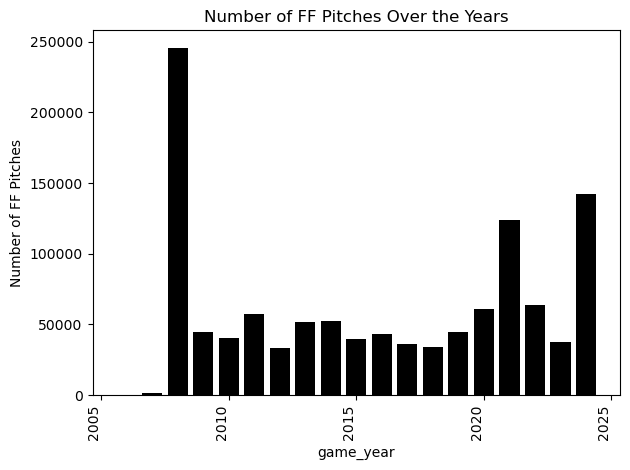

<Figure size 640x480 with 0 Axes>

In [25]:
fig = plt.figure(facecolor='white')
plt.bar(FF_year_df['game_year'],FF_year_df['count'],color='black')
plt.xlabel("game_year")
plt.ylabel("Number of FF Pitches")
plt.title("Number of FF Pitches Over the Years")
plt.xticks(rotation=90, ha='right')
plt.locator_params(axis="both", integer=True, tight=True)
fig.tight_layout()
plt.show()
plt.savefig('FF_by_year_bar.png')

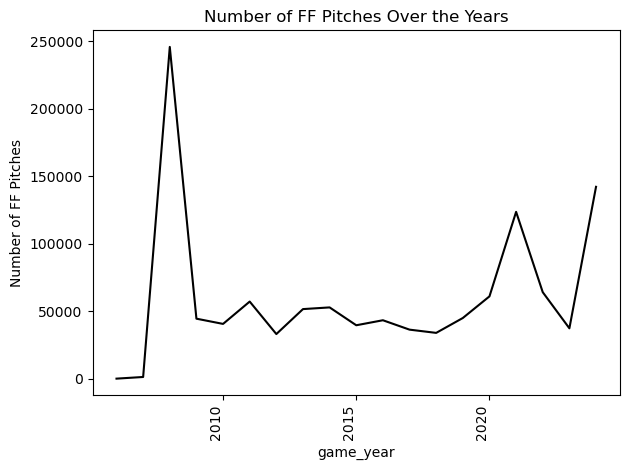

<Figure size 640x480 with 0 Axes>

In [26]:
fig = plt.figure(facecolor='white')
plt.plot(FF_year_df['game_year'],FF_year_df['count'],color='black')
plt.xlabel("game_year")
plt.ylabel("Number of FF Pitches")
plt.title("Number of FF Pitches Over the Years")
plt.xticks(rotation=90, ha='right')
plt.locator_params(axis="both", integer=True, tight=True)
fig.tight_layout()
plt.show()
plt.savefig('FF_by_year_line.png')

In [29]:
img_data = io.BytesIO()
fig.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-project-bucket-jl')
blob = bucket.blob("/figures/FF_by_year_line.png")
blob.upload_from_file(img_data)

In [33]:
#Frequency of FF based on zone
FF_zone_df = transformed_sdf.where(col("pitch_type") == 'FF').groupby("zone").count().sort('zone').toPandas()

24/12/14 03:20:25 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/12/14 03:20:54 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/12/14 03:20:54 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/12/14 03:20:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


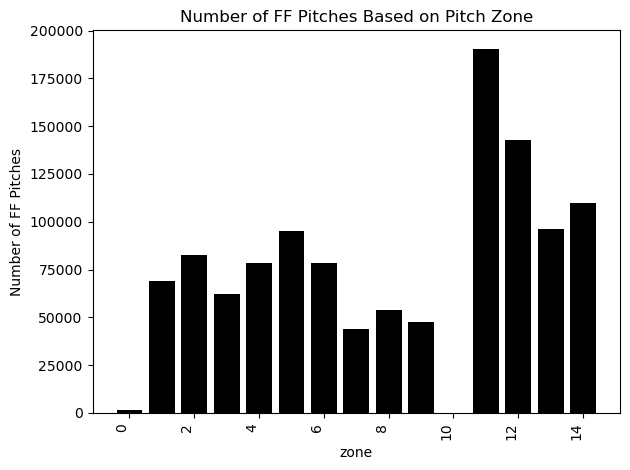

<Figure size 640x480 with 0 Axes>

In [34]:
fig = plt.figure(facecolor='white')
plt.bar(FF_zone_df['zone'],FF_zone_df['count'],color='black')
plt.xlabel("zone")
plt.ylabel("Number of FF Pitches")
plt.title("Number of FF Pitches Based on Pitch Zone")
plt.xticks(rotation=90, ha='right')
plt.locator_params(axis="both", integer=True, tight=True)
fig.tight_layout()
plt.show()
plt.savefig('FF_by_zone.png')

In [35]:
img_data = io.BytesIO()
fig.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-project-bucket-jl')
blob = bucket.blob("/figures/'FF_by_zone_bar.png")
blob.upload_from_file(img_data)

In [36]:
#Frequency of FF based on runner on base
FF_base_df = transformed_sdf.where(col("pitch_type") == 'FF').groupby(['player_on_1b','player_on_2b','player_on_3b']).count().sort(['player_on_1b','player_on_2b','player_on_3b']).toPandas()

24/12/14 03:21:24 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
24/12/14 03:21:53 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/12/14 03:21:53 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/12/14 03:21:55 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


In [37]:
FF_base_df['index'] = FF_base_df.index

In [38]:
FF_base_df['legend'] = ['No Runners','Runner on 3b','Runner on 2b','Runners on 2b and 3b',
                        'Runner on 1b','Runners on 1b and 3b','Runners on 1b and 2b','Bases Loaded']

In [39]:
FF_base_df

,player_on_1b,player_on_2b,player_on_3b,count,index,legend
0,0.0,0.0,0.0,677090,0,No Runners
1,0.0,0.0,1.0,26461,1,Runner on 3b
2,0.0,1.0,0.0,82797,2,Runner on 2b
3,0.0,1.0,1.0,20158,3,Runners on 2b and 3b
4,1.0,0.0,0.0,213636,4,Runner on 1b
5,1.0,0.0,1.0,30457,5,Runners on 1b and 3b
6,1.0,1.0,0.0,74438,6,Runners on 1b and 2b
7,1.0,1.0,1.0,27387,7,Bases Loaded


In [40]:
new_index = [0,4,6,5,2,3,1,7]
FF_base_df = FF_base_df.reindex(new_index)

In [41]:
FF_base_df

,player_on_1b,player_on_2b,player_on_3b,count,index,legend
0,0.0,0.0,0.0,677090,0,No Runners
4,1.0,0.0,0.0,213636,4,Runner on 1b
6,1.0,1.0,0.0,74438,6,Runners on 1b and 2b
5,1.0,0.0,1.0,30457,5,Runners on 1b and 3b
2,0.0,1.0,0.0,82797,2,Runner on 2b
3,0.0,1.0,1.0,20158,3,Runners on 2b and 3b
1,0.0,0.0,1.0,26461,1,Runner on 3b
7,1.0,1.0,1.0,27387,7,Bases Loaded


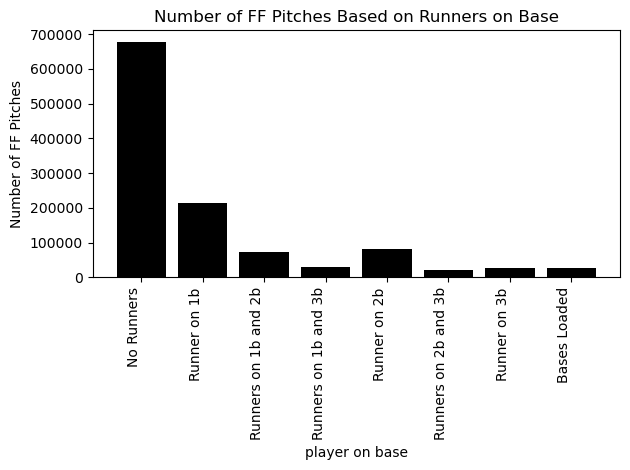

<Figure size 640x480 with 0 Axes>

In [42]:
#FF based on runners on base 
fig = plt.figure(facecolor='white')
plt.bar(FF_base_df['legend'],FF_base_df['count'],color='black')
plt.xlabel("player on base")
plt.ylabel("Number of FF Pitches")
plt.title("Number of FF Pitches Based on Runners on Base")
plt.xticks(rotation=90, ha='right')
fig.tight_layout()
plt.show()
plt.savefig('FF_by_runners_on_base.png')

In [43]:
img_data = io.BytesIO()
fig.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-project-bucket-jl')
blob = bucket.blob("/figures/'FF_by_runners_on_base.png")
blob.upload_from_file(img_data)

In [44]:
#Frequency of FF based on the count
FF_count_df = transformed_sdf.where(col("pitch_type") == 'FF').groupby(['balls','strikes']).count().sort(['balls','strikes']).toPandas()

24/12/14 03:22:30 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
24/12/14 03:22:57 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/12/14 03:22:58 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/12/14 03:22:59 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


In [45]:
FF_count_df['legend'] = ['0:0','0:1','0:2','1:0','1:1','1:2','2:0','2:1','2:2','3:0','3:1','3:2','4:2']

In [46]:
FF_count_df

,balls,strikes,count,legend
0,0.0,0.0,314337,0:0
1,0.0,1.0,129014,0:1
2,0.0,2.0,70545,0:2
3,1.0,0.0,119308,1:0
4,1.0,1.0,103058,1:1
5,1.0,2.0,95565,1:2
6,2.0,0.0,49923,2:0
7,2.0,1.0,63513,2:1
8,2.0,2.0,85239,2:2
9,3.0,0.0,22453,3:0


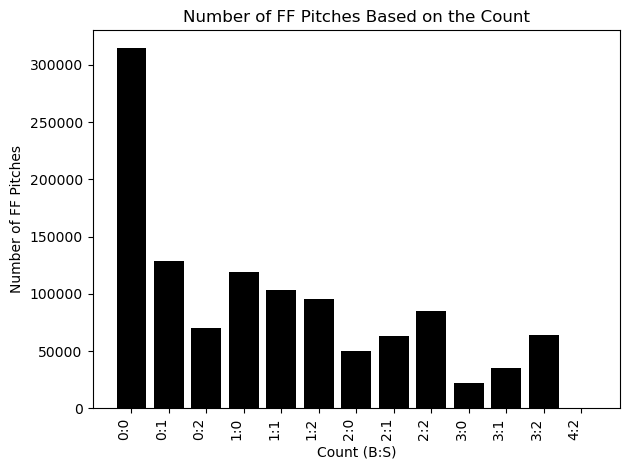

<Figure size 640x480 with 0 Axes>

In [47]:
#FF frequency based on count
fig = plt.figure(facecolor='white')
plt.bar(FF_count_df['legend'],FF_count_df['count'],color='black')
plt.xlabel("Count (B:S)")
plt.ylabel("Number of FF Pitches")
plt.title("Number of FF Pitches Based on the Count")
plt.xticks(rotation=90, ha='right')
fig.tight_layout()
plt.show()
plt.savefig('FF_by_count.png')

In [48]:
img_data = io.BytesIO()
fig.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-project-bucket-jl')
blob = bucket.blob("/figures/'FF_by_count.png")
blob.upload_from_file(img_data)

In [49]:
#FF frequency based on inning
FF_inning_df = transformed_sdf.where(col("pitch_type") == 'FF').groupby("inning").count().sort('inning').toPandas()

24/12/14 03:23:41 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/12/14 03:24:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/12/14 03:24:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/12/14 03:24:08 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


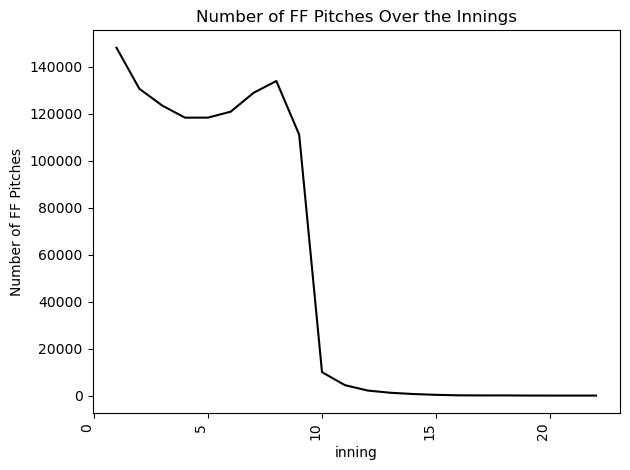

<Figure size 640x480 with 0 Axes>

In [50]:
fig = plt.figure(facecolor='white')
plt.plot(FF_inning_df['inning'],FF_inning_df['count'],color='black')
plt.xlabel("inning")
plt.ylabel("Number of FF Pitches")
plt.title("Number of FF Pitches Over the Innings")
plt.xticks(rotation=90, ha='right')
plt.locator_params(axis="both", integer=True, tight=True)
fig.tight_layout()
plt.show()
plt.savefig('FF_by_inning_line.png')

In [51]:
img_data = io.BytesIO()
fig.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-project-bucket-jl')
blob = bucket.blob("/figures/'FF_by_inning_line.png")
blob.upload_from_file(img_data)

In [30]:
#Frequency of FF in an average 9 inning game
FF_avg_inning_df = transformed_sdf.where((col("pitch_type") == 'FF') & (col("inning") < 10)).groupby("inning").count().sort('inning').toPandas()

24/12/14 03:19:08 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
24/12/14 03:19:51 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/12/14 03:19:52 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/12/14 03:19:53 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


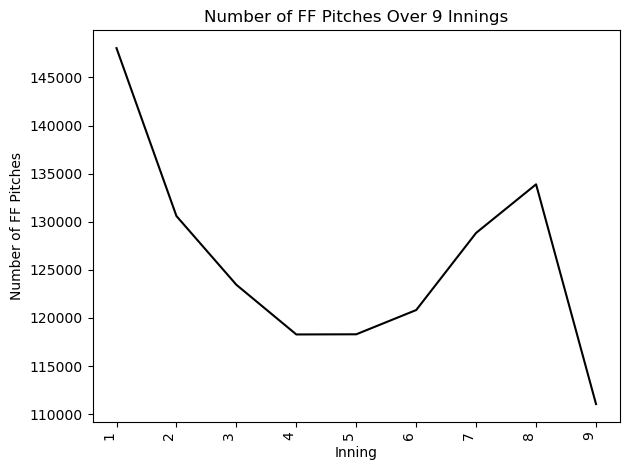

<Figure size 640x480 with 0 Axes>

In [31]:
fig = plt.figure(facecolor='white')
plt.plot(FF_avg_inning_df['inning'],FF_avg_inning_df['count'],color='black')
plt.xlabel("Inning")
plt.ylabel("Number of FF Pitches")
plt.title("Number of FF Pitches Over 9 Innings")
plt.xticks(rotation=90, ha='right')
plt.locator_params(axis="both", integer=True, tight=True)
fig.tight_layout()
plt.show()
plt.savefig('FF_pitches_Over_9_Innings.png')

In [32]:
img_data = io.BytesIO()
fig.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-project-bucket-jl')
blob = bucket.blob("/figures/“FF_pitches_Over_9_Innings”.png")
blob.upload_from_file(img_data)